### PIXEL MAPS, RMI CALCULATION AND EXPORT

In [1]:
from datetime import datetime
datetime.now().strftime("%Y-%m-%d %H:%M")

'2024-04-26 20:01'

In [2]:
%load_ext yamlmagic

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from matplotlib.colors import ListedColormap
from matplotlib import patches
from PIL import Image
import pandas as pd

In [129]:
path = r''
save_path = r''
conc = 2 #mg/mL of FITC D10S
font_size = 14
save_status = "save" #"save" to save the PNG files
reference = 0 #"No" if no reference shall be taken, otherwise, index
title_graph = ""
line_or_square = "s" #"l" to plot a line and "s" to plot a square of w width in pixels
w = 20 #Width of pixels to use for line
px_to_nm = 2.09

In [114]:
default_x = 750
default_y = 300
default_orientation = 1

def get_files(path):
    file_paths = [os.path.join(path,f) for f in sorted(os.listdir(path)) if f.endswith(".png")]
    filename =  [str(f) for f in sorted(os.listdir(path)) if f.endswith(".png")]
    return file_paths, filename

files = get_files(path)

# prefill options for images
s = """%%yaml conf

files:
"""
for fp, fn in zip(*files):
    s+=f"""
  - filename: r"{fn}"
    filepath: r"{fp}"
    orientation: {default_orientation} # 0 = horizontal, 1 = vertical
    line_pos_x: {default_x}  
    line_pos_y: {default_y} 
"""

get_ipython().set_next_input(s)

In [115]:
%%yaml conf

files:

  - filename: r"ROI 1.png"
    filepath: r"/Users/yaesu539/Library/CloudStorage/OneDrive-Uppsalauniversitet/PhD/DATA/Fluorescence microscope/Micromixers/Long Herringbone/120523/Graph/ROI 1.png"
    orientation: 1 # 0 = horizontal, 1 = vertical
    line_pos_x: 1790 
    line_pos_y: 300 

  - filename: r"ROI 2.png"
    filepath: r"/Users/yaesu539/Library/CloudStorage/OneDrive-Uppsalauniversitet/PhD/DATA/Fluorescence microscope/Micromixers/Long Herringbone/120523/Graph/ROI 2.png"
    orientation: 1 # 0 = horizontal, 1 = vertical
    line_pos_x: 52 
    line_pos_y: 300 

  - filename: r"ROI 3.png"
    filepath: r"/Users/yaesu539/Library/CloudStorage/OneDrive-Uppsalauniversitet/PhD/DATA/Fluorescence microscope/Micromixers/Long Herringbone/120523/Graph/ROI 3.png"
    orientation: 1 # 0 = horizontal, 1 = vertical
    line_pos_x: 57
    line_pos_y: 300 

  - filename: r"ROI 4.png"
    filepath: r"/Users/yaesu539/Library/CloudStorage/OneDrive-Uppsalauniversitet/PhD/DATA/Fluorescence microscope/Micromixers/Long Herringbone/120523/Graph/ROI 5.png"
    orientation: 1 # 0 = horizontal, 1 = vertical
    line_pos_x: 1250 
    line_pos_y: 300 


<IPython.core.display.Javascript object>

In [130]:
def get_conc_maps(path, conc, font_size, save_status, ref, conf):
    filepath, filename = get_files(path)
    if ref != "No":
        base_file = filepath[ref]
        pixel_basefile_G = get_pixels_RGB(base_file)
        max_pixelbf_G = np.max(pixel_basefile_G)
        k = conc/max_pixelbf_G
    if ref == "No":
        k = conc
    for fp, fn in zip(filepath, filename):
        pixel_conc = plot_surface(fp, k, fn, font_size, save_status)
        i = filepath.index(fp)
        if line_or_square == "s":
            linesquare_conc = get_square_conc(i, conf, pixel_conc, w)
        if line_or_square == "l":
            linesquare_conc = get_line_conc(i, conf, pixel_conc)
        conf['files'][i]['line_conc'] = linesquare_conc
    return conf 

def get_pixels_RGB(file):
    im = Image.open(file, 'r')
    pixel_RGB = np.array(im)
    pixel_G = np.float32(pixel_RGB[:,:,1])
    return (pixel_G)

def get_pixels_conc(pixel_G, k):
    max_pixel_G = np.max(pixel_G)
    if reference != "No":
        pixel_conc = (pixel_G * k)
        max_px = np.max(pixel_G)
        max_conc = np.max(pixel_conc)
    if reference == "No":
        pixel_conc = (pixel_G * k)/max_pixel_G
    return pixel_conc

%matplotlib widget
def plot_surface(file, k, title, font_size, save_status):
    pixel_G = get_pixels_RGB(file)
    pixel_conc = get_pixels_conc(pixel_G, k)
    plt.figure(figsize=(6,6))
    cmap = cm['inferno']
    newcolors = cmap(np.linspace(0, 1, 256))
    black = np.array([0, 0, 0, 1])
    newcolors[:50, :] = black
    newcmp = ListedColormap(newcolors)
    plt.imshow(pixel_conc, cmap = 'plasma', vmax=conc, vmin=0) #cmap='jet' to have full colors, OR cmap=newcmp to have black low conc values
    plt.colorbar(orientation='horizontal').set_label(label="FITC concentration (mg/mL)", size=font_size, fontweight='bold')
    title =  " " + title[:-4]
    plot_format(title_graph + title, font_size, save_status)
    return pixel_conc

def plot_format(title, font_size, save_status):
    #plt.title(title, size=font_size+2)
    plt.xlabel("Position (pixel)", size=font_size, fontweight='bold')
    plt.ylabel("Position (pixel)",size=font_size, fontweight='bold')
    #plt.xlim(880, 1915)
    plt.ylim(0, 400)
    if save_status == "save":
        plt.savefig(os.path.join(save_path, f"{title}.svg"), transparent=True)

def get_line_conc(i, conf, pixel_conc):
    if conf['files'][i]['orientation'] == 0:
        ys = conf['files'][i]['line_pos_y']   
        plt.axhline(y=ys, color="blue")
        plt.show()
        line_conc = pixel_conc[ys,:]
    if conf['files'][i]['orientation'] == 1:
        xs = conf['files'][i]['line_pos_x']   
        plt.axvline(x=xs, color="blue")
        plt.show()
        line_conc = pixel_conc[:, xs]
    assert len(line_conc) > 0
    return line_conc

def get_square_conc(i, conf, pixel_conc, w):
    if conf['files'][i]['orientation'] == 0:
        half_w = int(w/2)
        ys = conf['files'][i]['line_pos_y']   
        plt.axhspan(ys-half_w, ys+half_w, color='darkturquoise')
        plt.show()
        line_conc = pixel_conc[ys-half_w:ys+half_w, :].mean(axis=0)
    if conf['files'][i]['orientation'] == 1:
        half_w = int(w/2)
        xs = conf['files'][i]['line_pos_x'] 
        plt.axvspan(xs-half_w, xs+half_w, color='darkturquoise')
        plt.show()
        line_conc = pixel_conc[:, xs-half_w:xs+half_w].mean(axis=1)
    assert len(line_conc) > 0
    return line_conc



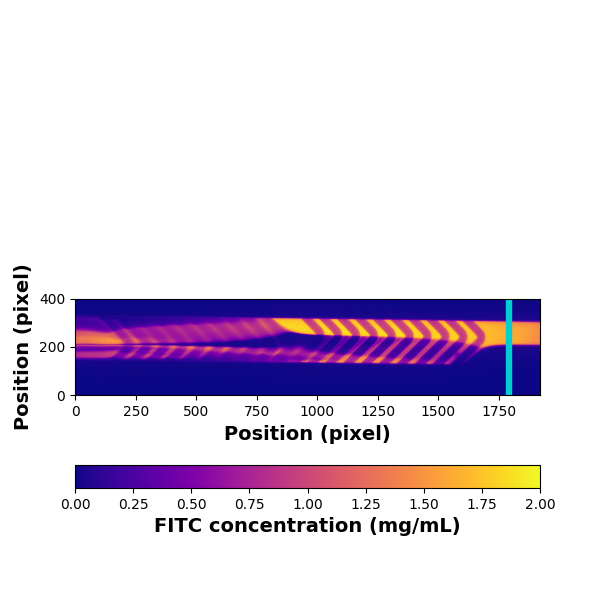

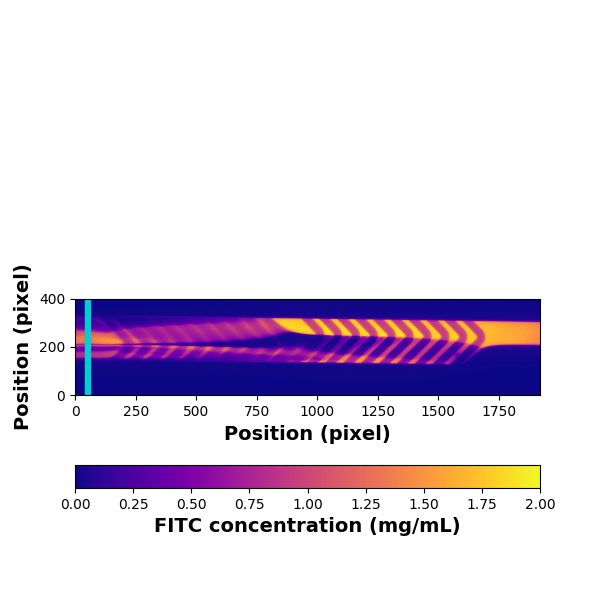

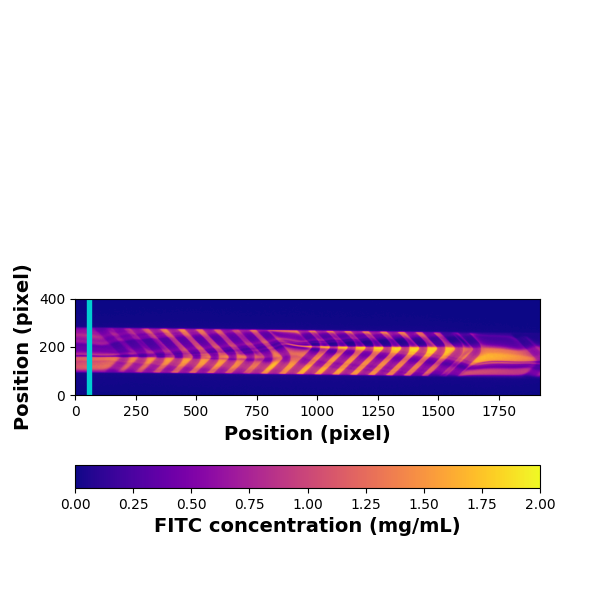

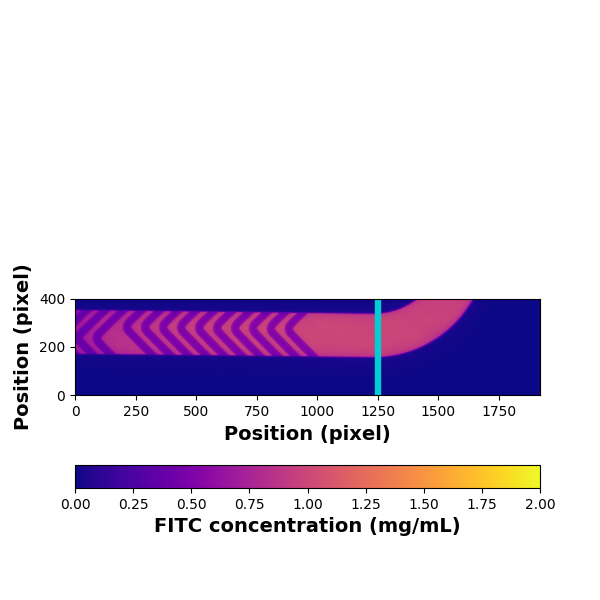

In [131]:
conf = get_conc_maps(path, conc, font_size, save_status, reference, conf)

In [146]:
def find_alignment_position(pixel_line):
    alignment_positions = []
    max_length = max(len(image) for image in pixel_line)  # Find the maximum length of images
    for px_l in pixel_line:
        if len(px_l) < max_length:
            px_l = np.pad(px_l, (0, max_length - len(px_l)), mode='constant')  # Pad image with zeros
        px_l = np.array(px_l)
        max_px_l = np.max(px_l)
        #diff = np.abs(np.diff(px_l))  # Calculate the absolute difference between each pixel and its previous pixel
        #partition_indices = np.argpartition(diff, -4)[-4:]  # Find indices of the four points with highest differences
        #alignment_position = np.min(partition_indices) + 1  # Find the leftmost position among the four points
        alignment_position = np.argwhere(px_l>0.25*max_px_l)[0][0]
        alignment_positions.append(alignment_position)
    return alignment_positions

def find_cuts(alignment_positions, pixel_values):
    min_ap = min(alignment_positions)
    new_pv = []
    for ap, pv in zip(alignment_positions, pixel_values):
        difference_ap = ap-min_ap
        new_pv.append(pv[difference_ap:])
    return new_pv

%matplotlib widget
def plot_line_conc_new(conf, new_pv, start, finish, n, colors):
    pv_notmixed = new_pv[reference] #pixel values of the reference image (unmixed)
    pv_notmixed_channel = pv_notmixed[start:finish]
    sigma_notmixed = np.std(pv_notmixed_channel) #sigma of the pixel values of unmixed
    plt.clf() #Clears the plot from previous runs
    for i, (l, pv, c) in enumerate(zip(conf['files'], new_pv, colors)):
        label = l['filename'].replace('r"', "").replace('.png"', "")
        plt.plot(np.arange(len(pv)), pv*norm_factor, label=label, linewidth=4, color=c)
        plt.axvline(x=start, color='lightgrey', linestyle='dashed', linewidth=3)
        plt.axvline(x=finish, color='lightgrey', linestyle='dashed', linewidth=3)
        pv_channel = pv[start:finish]
        sigma = np.std(pv_channel)
        RMI = 1 - (sigma/sigma_notmixed) # Relative Mixing Index (Hashmi et al, 2016)
        print(label, "RMI", RMI)
        conf['files'][i]['RMI'] = RMI
    plt.xlabel("Position (pixel)", fontsize = font_size, fontweight='bold')
    plt.ylabel("FITC concentration (mg/mL)", fontsize = font_size, fontweight='bold')
    plt.xticks(fontsize = font_size-2)
    plt.yticks(fontsize = font_size-2)
    plt.title(title_graph)
    plt.legend(fontsize = font_size-2)
    plt.xlim(75, 300)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()

def export_results(start, finish, w, px_to_nm, reference, conf, path_export, new_pv):
    width_px = finish - start
    width_nm = width_px * px_to_nm
    data = {
    'Start of measurement for RMI (px)': [start],
    'Finish of measurement RMI (px)': [finish],
    'Width of pixel line used for measurements of RMI (px)': [w],
    'nm/pixel equivalence (μm/px)': [px_to_nm],
    'Length of cross section of channel measured (px)': [width_px],
    'Length of cross section of channel measured (μm)': [width_nm],
    'Index of reference image, unmixed (index)': [reference]
    }
    df = pd.DataFrame(data).T.reset_index() 

    for i, file_data in enumerate(conf['files']):
        file_data['RMI'] = round(file_data['RMI'], 4)

    df_conf = pd.json_normalize(conf['files'])
    pv = pv_to_np_array(new_pv, start, finish)
    df_new_pv = pd.DataFrame(pv.T)
    df_new_pv.reset_index(inplace=True)
    df_new_pv.columns = ["Position [pixel]"]+[f['filename'].replace('r"', "").replace('.png"', "") for f in conf['files']]
    with pd.ExcelWriter(os.path.join(path, path_export, "results_mixing_efficiency.xlsx")) as writer:
        df.to_excel(writer, sheet_name='Configuration', index=False)
        df_conf.to_excel(writer, sheet_name='Conf', index=False)
        df_new_pv.to_excel(writer, sheet_name='Concentration profile', index=False)
    
    plt.savefig(os.path.join(path, path_export, "results_mixing_efficienc.png"))
    plt.savefig(os.path.join(path, path_export, "results_mixing_efficiency.svg"))

from typing import List
def pv_to_np_array(new_pv:List[List], start, finish)->np.ndarray:
    return np.array([curve[start:finish] for curve in new_pv])


ROI 1 RMI 0.0
ROI 2 RMI 0.45661425590515137
ROI 3 RMI 0.6500668525695801
ROI 4 RMI 0.9567180536687374


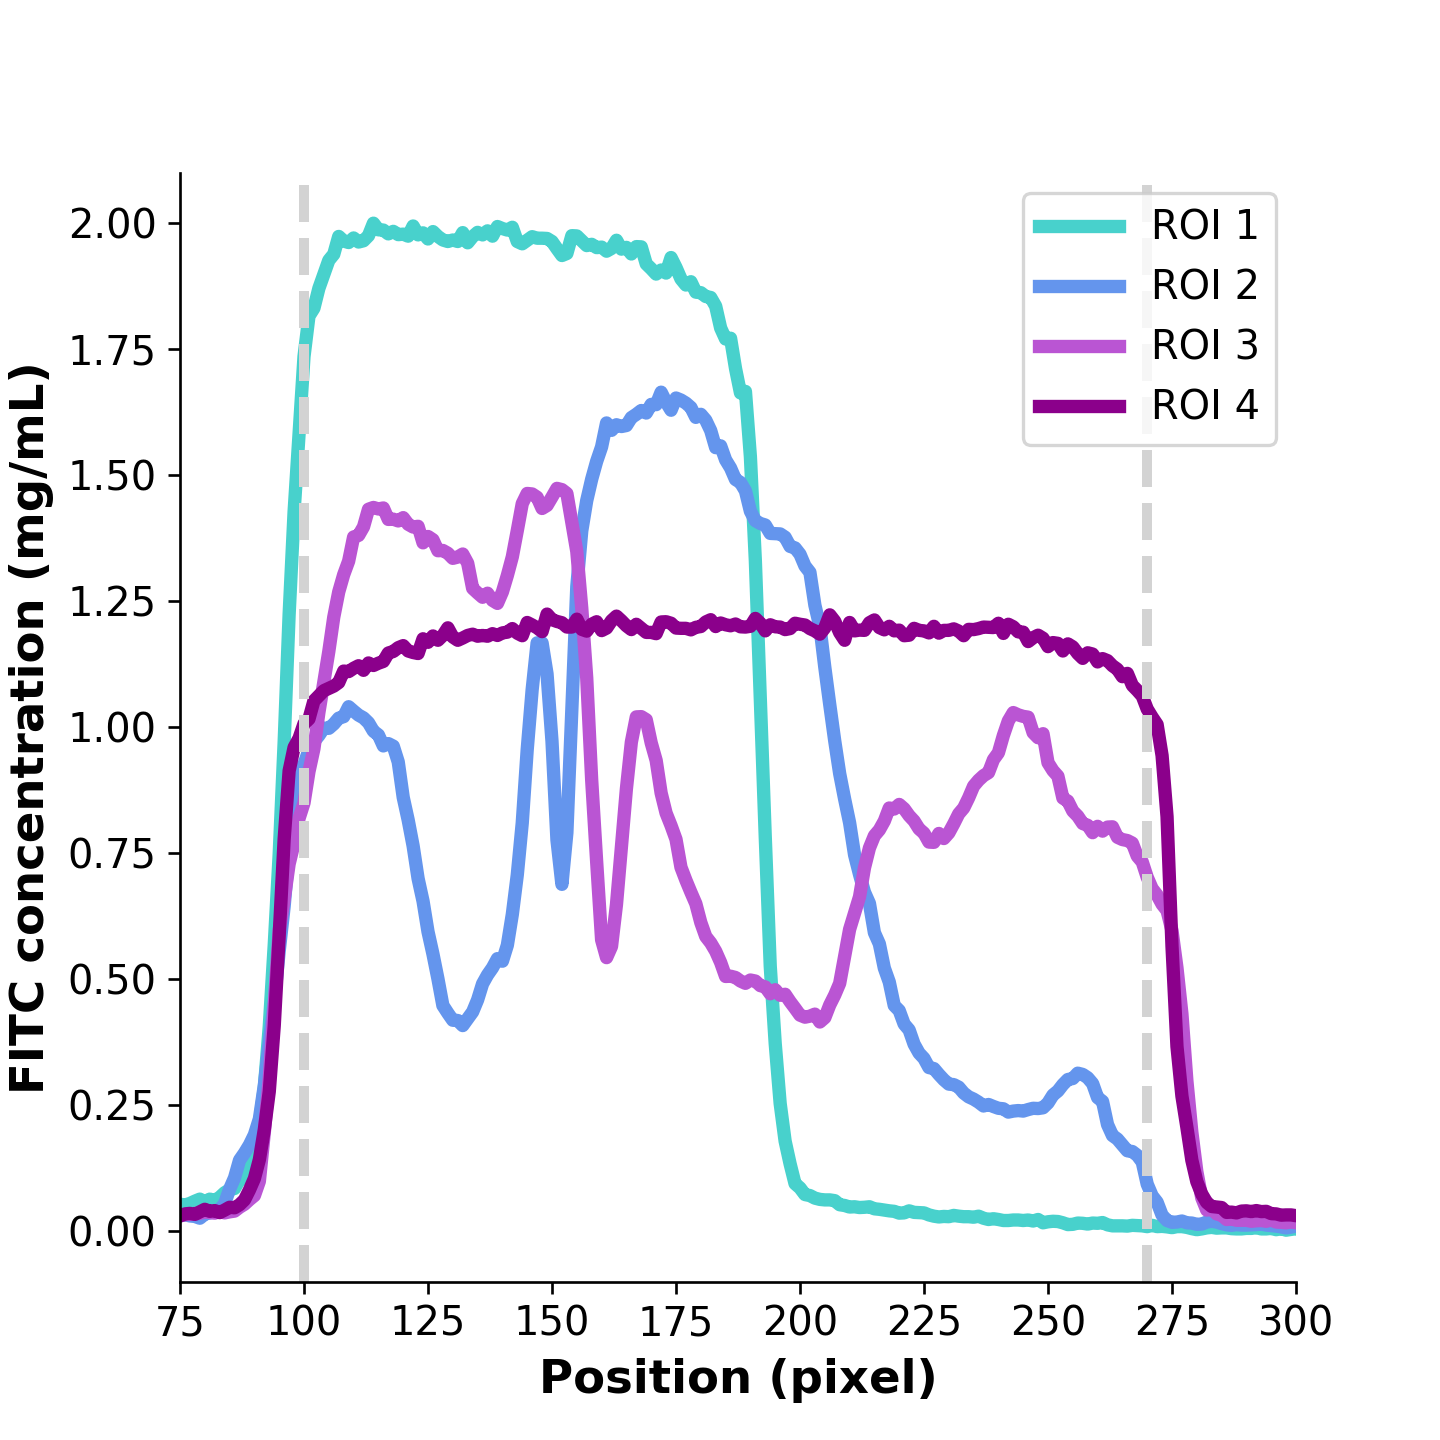

In [147]:
alignment_positions = []
pixel_values = []
max_val = 0
start = 100
finish = 270
colors = ["mediumturquoise", "cornflowerblue", "mediumorchid", "darkmagenta"]
path_export = r"/Users/yaesu539/Library/CloudStorage/OneDrive-Uppsalauniversitet/PhD/DATA/Fluorescence microscope/Micromixers/Long Herringbone/120523/Graph"
for i, l in enumerate(conf['files']):
    max_val_i = max(float(val) for val in l['line_conc'])
    if max_val_i > max_val:
        max_val = max_val_i
    norm_factor = conc/max_val
    pv = l['line_conc']
    line_pixel = [(float(val)) for val in l['line_conc']]  # Convert to list of floats
    alignment_positions.append(line_pixel) 
    pixel_values.append(pv)
alignment_position = find_alignment_position(alignment_positions)
new_pv = find_cuts(alignment_position, pixel_values)
plot_line_conc_new(conf, new_pv, start, finish, norm_factor, colors)
export_results(start, finish, w, px_to_nm, reference, conf, path_export, new_pv)


## Other Graphs

In [ ]:
def plot_line_conc(conf):
    for i, l in enumerate(conf['files']):
        label = l['filename'].replace('r"', "")
        label = label.replace('".png', "")
        c = l['line_conc']
        plt.plot(np.arange(len(c)), c, label=label)
        #ratio = get_mixing_efficiency(c)
        #ratio_perc = format(ratio * 100, '.1f') + '%'
        #conf['files'][i]['Mixing'] = ratio_perc
        #conf['files'][i]['ROI'] = label
    df = get_df(conf)
    #display(df[['ROI', 'Mixing']])
    plt.xlabel("Position [pixel]")
    plt.ylabel("FITC concentration [mg/mL]")
    plt.title(title_graph)
    plt.legend(title="ROI")
    plt.show()

def plot_line_conc_norm(conf):
    for i, l in enumerate(conf['files']):
        label = l['filename'].replace('r"', "")
        label = label.replace('".png', "")
        c = l['line_conc']
        plt.plot(np.arange(len(c)), c/conc, label=label)
        #ratio = get_mixing_efficiency(c)
        #ratio_perc = format(ratio * 100, '.1f') + '%'
        #conf['files'][i]['Mixing'] = ratio_perc
        #conf['files'][i]['ROI'] = label
    df = get_df(conf)
    #display(df[['ROI', 'Mixing']])
    plt.ylabel("C/C$_0$")
    plt.xlabel("Y/Y$_0$")
    plt.title(title_graph)
    plt.legend(title="ROI")
    plt.show()
    
def get_df(conf):
    return pd.DataFrame(x for x in conf['files'])

def get_mixing_efficiency(c):
    averaged_pixels = 100
    half = int(averaged_pixels/2)
    c = c[50:-50]
    n = len(c)
    if n >= 2*averaged_pixels:
        first = c[:half]
        last = c[-half:]
        avg_first = sum(first) / len(first)
        avg_last = sum(last) / len(last)
        ratio = avg_first / avg_last
    else:
        print("Array does not contain at least 100 elements")
    return ratio

In [ ]:
plot_line_conc(conf)
plot_line_conc_norm(conf)